# Velocity and acceleration diagnostics : geographical boxes histograms

- [ ] 2° bins histograms store in 


In [1]:
import os
from glob import glob

import numpy as np
import pandas as pd
import xarray as xr
import dask.dataframe as dd
import dask.array as da

#import cartopy.crs as ccrs
#import cartopy.feature as cfeature
#import geopandas as gpd
from shapely.geometry import Polygon

%matplotlib inline
from matplotlib import pyplot as plt


import drifters.utils as ut
import pynsitu as pin

from dask.delayed import delayed

import GDP_lib as gdp

from GDP_lib import root_dir

/home1/datahome/mdemol/.miniconda3/envs/mdenv/lib/python3.9/site-packages/pyTMD/tools.py:55: UserWarning: ipyleaflet not available
  warnings.warn("ipyleaflet not available")
/home1/datahome/mdemol/.miniconda3/envs/mdenv/lib/python3.9/site-packages/pyTMD/tools.py:56: UserWarning: Some functions will throw an exception if called
  warnings.warn("Some functions will throw an exception if called")


In [2]:
from dask.distributed import Client

if True:
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    #cluster = PBSCluster()
    #w = cluster.scale(jobs=3) # 2 not enough for lon, lat, year, binning
    cluster = PBSCluster(cores=3, processes=3, walltime='04:00:00')
    w = cluster.scale(jobs=8)
else:
    from dask.distributed import LocalCluster
    cluster = LocalCluster()
    
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.0.102:8787/status,
Dashboard: http://10.148.0.102:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.102:45423,Workers: 0
Dashboard: http://10.148.0.102:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


# Import

In [7]:
dl=2.0

In [8]:
zarr_gps_geohist = os.path.join(root_dir, f"gps_geohist_{dl}.zarr")
zarr_argos_geohist = os.path.join(root_dir, f"argos_geohist_{dl}.zarr")

In [11]:
dsg = xr.open_zarr(zarr_gps_geohist).persist()
dsa = xr.open_zarr(zarr_argos_geohist).persist()

In [13]:
dsg.sel(lon_bins = np.arange(30,40,2), lat_bins= np.arange(30,40,2), method='nearest')

<xarray.Dataset>
Dimensions:     (abins: 149, lon_bins: 5, lat_bins: 5, vbins: 149)
Coordinates:
  * abins       (abins) float64 -1.987e-05 -1.96e-05 ... 1.96e-05 1.987e-05
  * lat_bins    (lat_bins) float64 31.0 33.0 35.0 37.0 39.0
  * lon_bins    (lon_bins) float64 31.0 33.0 35.0 37.0 39.0
  * vbins       (vbins) float64 -1.987 -1.96 -1.933 -1.906 ... 1.933 1.96 1.987
Data variables:
    hist_ae     (lon_bins, lat_bins, abins) float64 dask.array<chunksize=(5, 5, 75), meta=np.ndarray>
    hist_aex    (lon_bins, lat_bins, abins) float64 dask.array<chunksize=(5, 5, 75), meta=np.ndarray>
    hist_an     (lon_bins, lat_bins, abins) float64 dask.array<chunksize=(5, 5, 75), meta=np.ndarray>
    hist_any    (lon_bins, lat_bins, abins) float64 dask.array<chunksize=(5, 5, 75), meta=np.ndarray>
    hist_ve     (lon_bins, lat_bins, vbins) float64 dask.array<chunksize=(5, 5, 75), meta=np.ndarray>
    hist_vex    (lon_bins, lat_bins, vbins) float64 dask.array<chunksize=(5, 5, 75), meta=np.ndarray>
    hist_vn     (lon_bins, lat_bins, vbins) float64 dask.array<chunksize=(5, 5, 75), meta=np.ndarray>
    hist_vny    (lon_bins, lat_bins, vbins) float64 dask.array<chunksize=(5, 5, 75), meta=np.ndarray>
    nb_geobins  (lon_bins, lat_bins) int64 dask.array<chunksize=(5, 5), meta=np.ndarray>

In [19]:
[i for i in list(dsg.keys() if i != 'nb_geobins')]

['hist_ae',
 'hist_aex',
 'hist_an',
 'hist_any',
 'hist_ve',
 'hist_vex',
 'hist_vn',
 'hist_vny',
 'nb_geobins']

In [23]:
def regional_histograms(ds, lon_sel, lat_sel, count_key = 'nb_geobins'):
    ds = ds.sel(lon_bins = lon_sel, lat_bins=lat_sel, method='nearest')
    nb_total = ds.nb_geobins.sum()
    l_var = [i for i in list(ds.keys()) if i != count_key]
    dsr = xr.Dataset()
    for l in l_var : 
        dsr[l]= ((ds[l]*ds[count_key]).sum(['lon_bins', 'lat_bins']))/nb_total
    dsr['nb_geobins'] = nb_total
    return dsr

In [32]:
#Gulf Stream
dsgr_gs = regional_histograms(dsg, np.arange(125,140,2), np.arange(15,30,2)).compute()
#ACC
dsgr_acc = regional_histograms(dsg, np.arange(60,120,2), np.arange(-60,-35,2)).compute()
#South atlantic gyre
dsgr_sag = regional_histograms(dsg, np.arange(-40,0,2), np.arange(-20,-5,2)).compute()

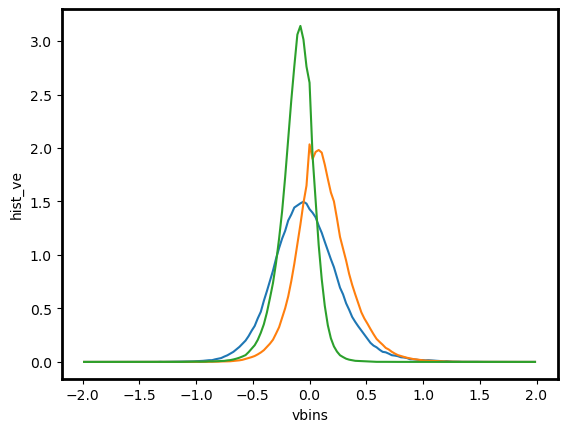

In [35]:
dsgr_gs.hist_ve.plot()
dsgr_acc.hist_ve.plot()
dsgr_sag.hist_ve.plot()  #normaliser

In [29]:
#Gulf Stream
lon_sel = np.arange(125,140,2)
lat_sel = np.arange(-60,,2)
#south atlantic gyre
dsgr = regional_histograms(dsg, lon_sel, lat_sel).compute()

In [30]:
dsgr

<xarray.Dataset>
Dimensions:     (abins: 149, vbins: 149)
Coordinates:
  * abins       (abins) float64 -1.987e-05 -1.96e-05 ... 1.96e-05 1.987e-05
  * vbins       (vbins) float64 -1.987 -1.96 -1.933 -1.906 ... 1.933 1.96 1.987
Data variables:
    hist_ae     (abins) float64 1.156e+04 1.16e+04 ... 1.151e+04 1.19e+04
    hist_aex    (abins) float64 1.07e+04 1.114e+04 ... 1.107e+04 1.132e+04
    hist_an     (abins) float64 9.979e+03 9.613e+03 ... 9.982e+03 1e+04
    hist_any    (abins) float64 9.58e+03 1.013e+04 ... 1.081e+04 9.75e+03
    hist_ve     (vbins) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0001058 0.0001058 0.0
    hist_vex    (vbins) float64 0.0 0.0 0.0 0.0 ... 0.0001057 0.0001058 0.0
    hist_vn     (vbins) float64 0.0 0.0 0.0 ... 0.0003173 0.0003174 0.0004231
    hist_vny    (vbins) float64 0.0002117 0.0006353 ... 0.0007409 0.0009528
    nb_geobins  int64 352311

In [112]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
